In [1]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logit
from abc import ABC, abstractmethod
from matplotlib import cm

In [2]:
np.random.seed(1)

In [3]:
class AbstractLoss(ABC):
 
    def __init__(self, p1lim, p2lim, granularity = 1000):
        # Storing parameters
        self.granularity = granularity
        # Preprocess data
        self.p1 = np.linspace(p1lim[0], p1lim[1], granularity)
        self.p2 = np.linspace(p2lim[0], p2lim[1], granularity)
        self.p1p1, self.p2p2 = np.meshgrid(self.p1, self.p2)
        
        super().__init__()
        
    @abstractmethod
    def _calculate_gradient(self, x, y, current_params):
        pass
    
    @abstractmethod
    def produce_dataset(self):
        pass
    
    @abstractmethod
    # Grid approximation if params = None, otherwise, calculate for a specific combination of parameters
    def calculate_loss_2D(self, params = None):
        pass
    
    @abstractmethod
    def _plot_model(self, *args):
        pass
    
    def _plot_gradient_descent_2D(self, values):
        fig, ax = self.plot_loss_2D() 
        ax.plot(values[:, 0], 
                values[:, 1], 
                marker = 'x', 
                linestyle = '-', 
                color = 'r', 
                markerfacecolor = 'r', 
                markeredgecolor = 'r') 
    
    def plot_loss_2D(self):
        fig, ax = plt.subplots()
        ax.contourf(self.p1, self.p2, self.l, cmap = cm.coolwarm, alpha = 0.5)
        ax.set_xlabel(self.param_names[0])
        ax.set_ylabel(self.param_names[1])
        
        return fig, ax
    
    def plot_loss_1D(self, axis, index):
        fig, ax = plt.subplots()
        if axis == 0:
            self.l1d = self.l[index, :]
            x = self.p1
            param = self.param_names[0]
            other = self.param_names[1] + ' = ' + str(self.p2[index])
        elif axis == 1:
            self.l1d = self.l[:, index]
            x = self.p2
            param = self.param_names[1]
            other = self.param_names[0] + ' = ' + str(self.p1[index])
        else:
            raise ValueError('Incorrect axis value')
            
        ax.plot(x, self.l1d)
        ax.set_xlabel(param)
        ax.set_ylabel('loss')
        ax.set_title(other)
        
        return fig, ax
        
    def gridsearch_loss_2D(self):
        fig, ax = self.plot_loss_2D()
        
        minimum = np.unravel_index(np.argmin(self.l), self.l.shape)
        print('Gridsearch minimum:')
        print(self.param_names[0] + ': ' + str(self.p1p1[minimum]))
        print(self.param_names[1] + ': ' + str(self.p2p2[minimum]))
        print('Loss function value: ' + str(self.l[minimum]))
        ax.plot(self.p1p1[minimum], 
                self.p2p2[minimum], 
                markerfacecolor = 'red', 
                markeredgecolor = 'red', 
                marker = 'x', 
                markersize = 5)
        
        self._plot_model(self.p1p1[minimum], self.p2p2[minimum])
        
    def gridsearch_loss_1D(self, axis, index):
        fig, ax = self.plot_loss_1D(axis, index)
        
        # The incorrect index calue exception is already raised in the plot_loss_1D function
        if axis == 0:
            x = self.p1
            name = self.param_names[0]
        else:
            x = self.p2
            name = self.param_names[1]
            
        minimum = np.argmin(self.l1d)
        print('Gridsearch minimum:')
        print(name + ': ' + str(x[minimum]))
        print('Loss function value: ' + str(self.l1d[minimum]))
        ax.plot(x[minimum], 
                self.l1d[minimum], 
                markerfacecolor = 'red',
                markeredgecolor = 'red', 
                marker = 'o', 
                markersize = 5)
        
    def _plot_gradient_descent(self, values):
        pass
        
    def steepest_gradient_descend_2D(self, 
                                     initial_p1_index,
                                     initial_p2_index,
                                     learning_rate = 0.01, 
                                     stop_threshold = 0.0001):
        
        params_history = [[initial_p1_index + stop_threshold, initial_p2_index + stop_threshold]]
        current_params = [initial_p1_index, initial_p2_index]
        
        while np.sum(np.abs(np.array(current_params) - np.array(params_history[-1]))) > stop_threshold:
            params_history.append(current_params)
            current_params = (np.array(current_params) - \
                              learning_rate * np.array(self._calculate_gradient(self.x, 
                                                                                self.y, 
                                                                                current_params))).tolist()
            
        print('Steepest gradient descent (' +  str(len(params_history)) + ' iterations):')
        print(self.param_names[0] + ': ' + str(current_params[0]))
        print(self.param_names[1] + ': ' + str(current_params[1]))
        print('Loss function value: ' + str(self.calculate_loss_2D(current_params)))
        
        self._plot_gradient_descent_2D(np.array(params_history[1:]))

$L = \frac{1}{n}\displaystyle\sum_i(y_i - \beta_0 - \beta_1 x_i)^2$

$\frac{\partial L}{\partial b_1} = - \frac{1}{n}\displaystyle\sum_i2x_i(y_i - \beta_0 - \beta_1 x_i)$

$\frac{\partial L}{\partial b_0} = -\frac{1}{n}\displaystyle\sum_i2(y_i - \beta_0 - \beta_1 x_i)$

In [4]:
class LinearRegressionLoss(AbstractLoss):
    def __init__(self, xlim, b0, b1, n, p1lim, p2lim, granularity = 1000):
        super().__init__(p1lim, p2lim, granularity)
        self.param_names = ['b0', 'b1']
        self.xlim = xlim
        self.b0 = b0
        self.b1 = b1
        self.n = n
        
    def _calculate_gradient(self, x, y, current_params):
        # Partial derivative with respect to b_1
        d_b1 = np.mean(np.multiply(-2 * x, y - current_params[0] - current_params[1] * x))
        # Partial derivative with respect to b_0
        d_b0 = np.mean(-2 * (y - current_params[0] - current_params[1] * x))

        return [d_b0, d_b1]
        
    def produce_dataset(self):
        self.x = np.linspace(self.xlim[0], self.xlim[1], self.n)
        self.y = self.b1 * self.x + self.b0 + np.random.rand(self.n)
        
    def calculate_loss_2D(self, params = None):
        xp = np.vstack((np.ones((1, self.x.shape[0])), self.x)).T
        if params is None:
            b = np.vstack((self.p1p1.flatten(), self.p2p2.flatten()))
            yp = np.dot(xp, b)
            yl = np.repeat(self.y, self.granularity * self.granularity) \
                   .reshape(self.y.shape[0], self.granularity * self.granularity)
            self.l = np.mean(np.power(yl - yp, 2), axis = 0).reshape(self.granularity, self.granularity)
        else:
            yp = np.dot(xp, params)
            return np.mean(np.power(self.y - yp, 2), axis = 0)
            
        
    def _plot_model(self, *args):
        fig, ax = plt.subplots()
        ax.plot(self.x, self.y, 'o')
        ax.plot(self.x, self.x * args[1] + args[0])
        ax.set_title('beta_0 = ' + str(args[0].round(2)) + ', beta_1 = ' + str(args[1].round(2)))

$L = -\displaystyle\prod_i \left(\frac{e^{\beta_0 + \beta_1 x}}{1 + e^{\beta_0 + \beta_1 x}}\right)^{y} \left({1 - \frac{e^{\beta_0 + \beta_1 x}}{1 + e^{\beta_0 + \beta_1 x}}}\right) ^ {1 - y} $

$\log(L) = -\displaystyle\sum_i y\log\left(\frac{e^{\beta_0 + \beta_1 x}}{1 + e^{\beta_0 + \beta_1 x}}\right) + (1-y)\log\left({1 - \frac{e^{\beta_0 + \beta_1 x}}{1 + e^{\beta_0 + \beta_1 x}}}\right) $

$\frac{\partial \log(L)}{\partial b_0} = -\displaystyle\sum_i\frac{y-(1-y)e^{\beta_0 + \beta_1 x}}{1 + e^{\beta_0 + \beta_1 x}}$

$\frac{\partial \log(L)}{\partial b_1} = -\displaystyle\sum_i\frac{yx-(1-y)xe^{\beta_0 + \beta_1 x}}{1 + e^{\beta_0 + \beta_1 x}}$

In [5]:
class LogisticRegressionLoss(AbstractLoss):
    def __init__(self, mu1, std1, n1, mu2, std2, n2, p1lim, p2lim, granularity = 1000):
        super().__init__(p1lim, p2lim, granularity)
        self.param_names = ['b0', 'b1']
        self.mu1 = mu1
        self.std1 = std1
        self.n1 = n1
        self.mu2 = mu2
        self.std2 = std2
        self.n2 = n2
        
    def _calculate_gradient(self, x, y, current_params):
        def exponent(current_params, x):
            return math.exp(current_params[0] + current_params[1] * x)
        
        # Partial derivative with respect to b_1
        d_b1 = - np.sum([(y_i * x_i - x_i * (1 - y_i) * exponent(current_params, x_i)) / \
                         (1 + exponent(current_params, x_i)) \
                         for x_i, y_i in zip(x, y)])
        # Partial derivative with respect to b_0
        d_b0 = - np.sum([(y_i - (1 - y_i) * exponent(current_params, x_i)) / \
                         (1 + exponent(current_params, x_i)) \
                         for x_i, y_i in zip(x, y)])
       
        return [d_b0, d_b1]
        
    def produce_dataset(self):
        self.x = np.hstack((np.random.normal(loc = self.mu1, scale = self.std1, size = self.n1),
                            np.random.normal(loc = self.mu2, scale = self.std2, size = self.n2)))
        self.y = np.hstack((np.zeros(self.n1), np.ones(self.n2)))
        
    def calculate_loss_2D(self, params = None):
        b = np.vstack((self.p1p1.flatten(), self.p2p2.flatten()))
        xp = np.vstack((np.ones((1, self.x.shape[0])), self.x)).T
        yp = np.exp(np.dot(xp, b))/(1 + np.exp(np.dot(xp, b)))
        yl = np.repeat(self.y, self.granularity * self.granularity) \
               .reshape(self.y.shape[0], self.granularity * self.granularity)

        # Taking the negative of the loss function so it becomes a minimisation problem
        self.l = -np.prod(np.multiply(np.power(yp, yl), np.power(1 - yp, 1 - yl)), axis = 0) \
                    .reshape(self.granularity, self.granularity)
        
    def _plot_model(self, *args):
        fig, ax = plt.subplots()
        
        ax.plot(self.x, self.y, 'o')
        
        if self.mu1 < self.mu2:
            mu1, mu2, std1, std2 = self.mu1, self.mu2, self.std1, self.std2
        else:
            mu1, mu2, std1, std2 = self.mu2, self.mu1, self.std1, self.std1
        xl = np.linspace(mu1 - 3 * std1, mu2 + 3 * std2, self.granularity)
        p = np.exp(xl * args[1] + args[0]) / (1 + np.exp(xl * args[1] + args[0]))
        ax.plot(xl, p)

In [6]:
class StyblinskiTangLoss(AbstractLoss):
    def __init__(self, p1lim, p2lim, granularity = 1000):
        super().__init__(p1lim, p2lim, granularity)
        self.param_names = ['x', 'y']
        
    def produce_dataset(self):
        pass
        
    def calculate_loss_2D(self, params = None):
        xp, yp = np.meshgrid(self.p1, self.p2)
        xp, yp = xp.flatten(), yp.flatten()

        self.l = (0.5 * ((np.power(xp, 4) - 16 * np.power(xp, 2) + 5 * xp) + \
                         (np.power(yp, 4) - 16 * np.power(yp, 2) + 5 * yp))).reshape(self.granularity, self.granularity)
        
    def _plot_model(self, *args):
        pass

## Linear regression

Note: the estimation of b_0 and b_1 may differ from the constants due to the introduced noise. 

In [7]:
lrl = LinearRegressionLoss(xlim = [-1, 2],
                           b0 = 0.6,
                           b1 = 1.7,
                           n = 11,
                           p1lim = [-10, 10],
                           p2lim = [-10, 10])

In [8]:
lrl.produce_dataset()

In [9]:
lrl.calculate_loss_2D()

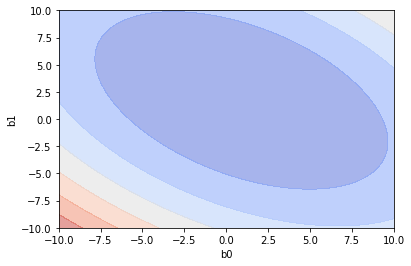

In [10]:
_ = lrl.plot_loss_2D()

Gridsearch minimum:
b0: 0.9109109109109106
b1: 1.711711711711711
Loss function value: 0.039441269435046916


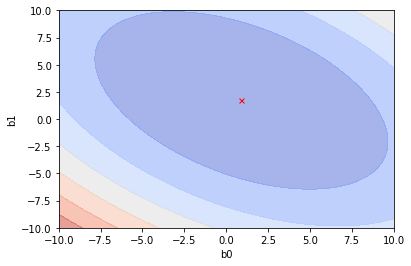

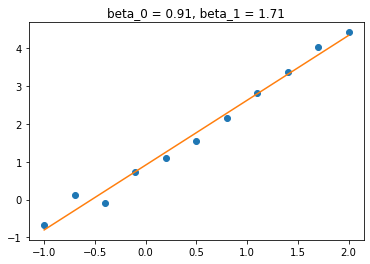

In [11]:
lrl.gridsearch_loss_2D()

Gridsearch minimum:
b0: 0.9109109109109106
Loss function value: 0.039520696360734214


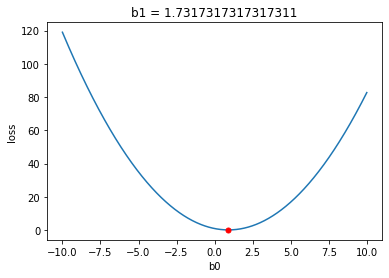

In [12]:
lrl.gridsearch_loss_1D(0, 586)

Steepest gradient descent (80 iterations):
b0: 0.9154041416233974
b1: 1.7178849158515777
Loss function value: 0.039349170037375675


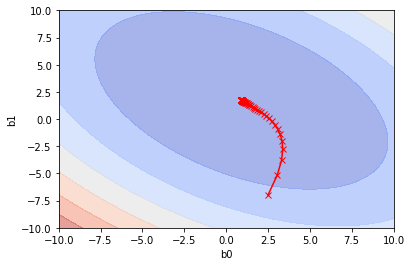

In [13]:
lrl.steepest_gradient_descend_2D(learning_rate = 0.1, initial_p1_index = 2.5, initial_p2_index = -7)

## Logistic regression

In [14]:
lgl = LogisticRegressionLoss(mu1 = -1,
                             std1 = 2,
                             n1 = 10,
                             mu2 = 1,
                             std2 = 2,
                             n2 = 10,
                             p1lim = [-1.5, 0.9],
                             p2lim = [0, 1.7])

In [15]:
lgl.produce_dataset()

In [16]:
lgl.calculate_loss_2D()

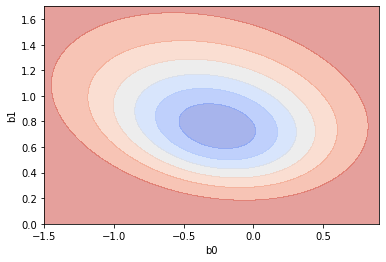

In [17]:
_ = lgl.plot_loss_2D()

Gridsearch minimum:
b0: -0.25555555555555554
b1: 0.7538538538538538
Loss function value: -4.057962040203876e-05


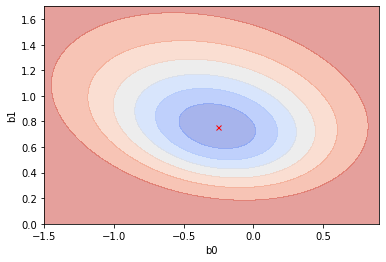

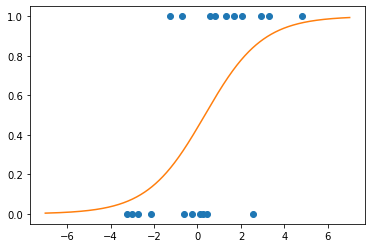

In [18]:
lgl.gridsearch_loss_2D()

Gridsearch minimum:
b0: -0.25555555555555554
Loss function value: -4.057962040203876e-05


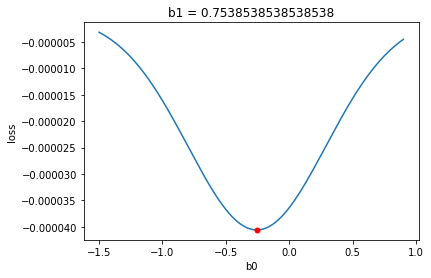

In [19]:
lgl.gridsearch_loss_1D(0, 443)

Steepest gradient descent (23 iterations):
b0: -0.2555103034520268
b1: 0.7535517276687487
Loss function value: None


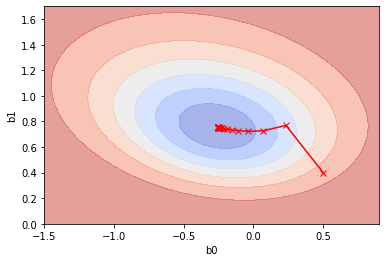

In [20]:
lgl.steepest_gradient_descend_2D(learning_rate = 0.1, initial_p1_index = 0.5, initial_p2_index = 0.4)

## Test function (local minima)

Styblinski-Tang function - https://www.sfu.ca/~ssurjano/stybtang.html

Partial derivatives https://es.symbolab.com/solver/partial-derivative-calculator/

Minimum at (-3, -3)

In [21]:
stl = StyblinskiTangLoss(p1lim = [-5, 5], p2lim = [-5, 5])

TypeError: Can't instantiate abstract class StyblinskiTangLoss with abstract methods _calculate_gradient

In [ ]:
stl.calculate_loss_2D()

In [ ]:
_ = stl.plot_loss_2D()

In [ ]:
stl.gridsearch_loss_2D()

In [ ]:
stl.gridsearch_loss_1D(0, 209)